In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
from tqdm.notebook import tqdm

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
spacy_ru = spacy.load('ru_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_ru(text):
    """
    Tokenizes Russian text from a string into a list of strings
    """
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [8]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_ru, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [9]:
path_to_data = "../data.txt"

In [10]:
dataset = TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [11]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [12]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [13]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [15]:
from gensim.models import KeyedVectors

In [16]:
%%time
en_emb = KeyedVectors.load_word2vec_format("./pretrained_embeddings/cc.en.300.vec")

CPU times: user 3min 34s, sys: 2.21 s, total: 3min 36s
Wall time: 3min 35s


In [17]:
%%time
ru_emb = KeyedVectors.load_word2vec_format("./pretrained_embeddings/cc.ru.300.vec")

CPU times: user 3min 41s, sys: 2.23 s, total: 3min 43s
Wall time: 3min 43s


In [14]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

In [15]:
from my_network import Attention, Encoder, Decoder, Seq2Seq

In [16]:
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

In [17]:
model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6802, 300)
    (rnn): GRU(300, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(9318, 300)
    (rnn): GRU(1324, 512)
    (fc_out): Linear(in_features=1836, out_features=9318, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [25]:
en_emb_ordered = [en_emb.get_vector("UNK"), en_emb.get_vector("PAD"), en_emb.get_vector("SOS"), en_emb.get_vector("EOS")]
for token in tqdm(SRC.vocab.itos[4:]):
    try:
        en_emb_ordered.append(en_emb.get_vector(token))
    except KeyError:
        en_emb_ordered.append(np.random.normal(size=ENC_EMB_DIM))

  0%|          | 0/6798 [00:00<?, ?it/s]

In [26]:
ru_emb_ordered = [ru_emb.get_vector("UNK"), ru_emb.get_vector("PAD"), ru_emb.get_vector("SOS"), ru_emb.get_vector("EOS")]
for token in tqdm(TRG.vocab.itos[4:]):
    try:
        ru_emb_ordered.append(ru_emb.get_vector(token))
    except KeyError:
        ru_emb_ordered.append(np.random.normal(size=DEC_EMB_DIM))

  0%|          | 0/9314 [00:00<?, ?it/s]

In [27]:
en_emb_ordered = np.array(en_emb_ordered)
ru_emb_ordered = np.array(ru_emb_ordered)

In [28]:
for name, mod in enc.named_modules():
    if name == "embedding":
        mod = nn.Embedding.from_pretrained(torch.FloatTensor(en_emb_ordered))
        
for name, mod in dec.named_modules():
    if name == "embedding":
        mod = nn.Embedding.from_pretrained(torch.FloatTensor(ru_emb_ordered))

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 28,589,198 trainable parameters


In [30]:
optimizer = optim.Adam(model.parameters())

In [23]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [20]:
from my_utils import train_gru, evaluate_gru, epoch_time

In [35]:
for x in train_iterator:
    break

In [36]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(model, input_to_model=(*x.src, x.trg, torch.LongTensor(1)))
writer.close()

<ipython-input-13-ea8c6dc9004d>:64: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert (output == hidden).all()
<ipython-input-14-73ff751608d6>:58: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  input = trg[t] if teacher_force else top1


In [37]:
%load_ext tensorboard
%tensorboard --logdir runs

In [38]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_gru(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate_gru(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "./models/lstm_lstm_with_attention_pretrained_embeddings.pt")
    
    writer.add_scalar('mean train loss per epoch', train_loss, global_step=epoch)
    writer.add_scalar('mean val loss per epoch', valid_loss, global_step=epoch)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 18s
	Train Loss: 5.068 | Train PPL: 158.927
	 Val. Loss: 4.913 |  Val. PPL: 136.060
Epoch: 02 | Time: 1m 19s
	Train Loss: 3.587 | Train PPL:  36.134
	 Val. Loss: 4.591 |  Val. PPL:  98.591
Epoch: 03 | Time: 1m 18s
	Train Loss: 3.021 | Train PPL:  20.511
	 Val. Loss: 4.432 |  Val. PPL:  84.119
Epoch: 04 | Time: 1m 19s
	Train Loss: 2.638 | Train PPL:  13.988
	 Val. Loss: 4.320 |  Val. PPL:  75.221
Epoch: 05 | Time: 1m 20s
	Train Loss: 2.347 | Train PPL:  10.449
	 Val. Loss: 4.190 |  Val. PPL:  66.047
Epoch: 06 | Time: 1m 18s
	Train Loss: 2.125 | Train PPL:   8.376
	 Val. Loss: 4.312 |  Val. PPL:  74.580
Epoch: 07 | Time: 1m 19s
	Train Loss: 1.923 | Train PPL:   6.842
	 Val. Loss: 4.290 |  Val. PPL:  72.990
Epoch: 08 | Time: 1m 18s
	Train Loss: 1.802 | Train PPL:   6.062
	 Val. Loss: 4.339 |  Val. PPL:  76.666
Epoch: 09 | Time: 1m 21s
	Train Loss: 1.648 | Train PPL:   5.196
	 Val. Loss: 4.502 |  Val. PPL:  90.188
Epoch: 10 | Time: 1m 17s
	Train Loss: 1.552 | Train PPL

In [39]:
torch.cuda.empty_cache()

In [21]:
model.load_state_dict(torch.load("./models/lstm_lstm_with_attention_pretrained_embeddings.pt"))

<All keys matched successfully>

In [24]:
num_batches = len(test_data.examples) // test_iterator.batch_size
start_time = time.time()
test_loss = evaluate_gru(model, test_iterator, criterion)
elapsed_time = (time.time() - start_time) 
time_per_32_batch = elapsed_time / num_batches / 4

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Inference time if batch_size=32: {time_per_32_batch:.3f} sec')

| Test Loss: 4.217 | Test PPL:  67.834 | Inference time if batch_size=32: 0.022 sec


In [2]:
from my_utils import gru_display_attention, gru_translate_sentence

In [43]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = some of the suites feature a spa bath .
trg = в некоторых люксах установлена гидромассажная ванна .


In [44]:
translation, attention = gru_translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {" ".join(translation)}')

predicted trg = в некоторых люксах есть гидромассажная ванна . <eos>


<ipython-input-42-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-42-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


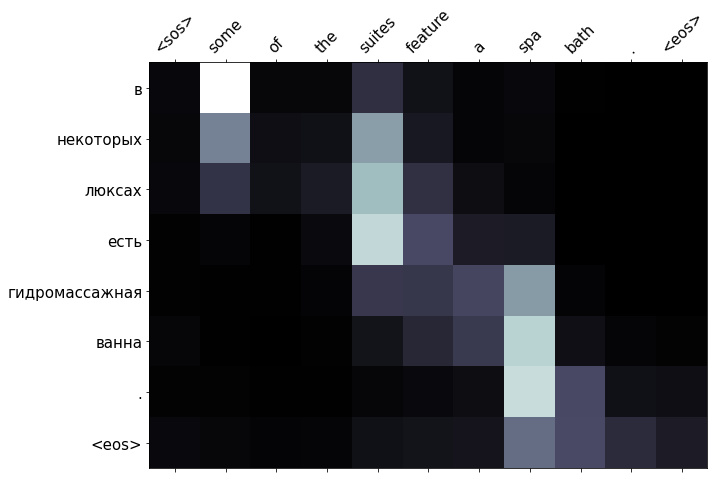

In [45]:
gru_display_attention(src, translation, attention)

In [46]:
example_idx = 7

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = breakfast is available as well .
trg = для гостей сервируется завтрак .


predicted trg = завтрак сервируется завтрак . <eos>


<ipython-input-42-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-42-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


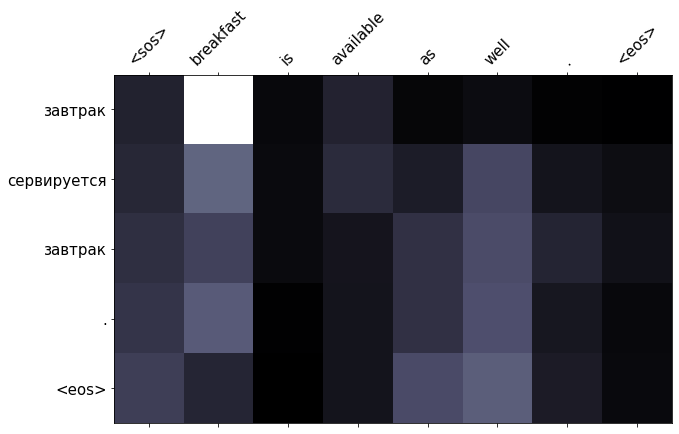

In [47]:
translation, attention = gru_translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {" ".join(translation)}')

gru_display_attention(src, translation, attention)

In [48]:
example_idx = 21

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = it offers a sun terrace with an outdoor pool and a poolside bar .
trg = к услугам гостей солнечная терраса с открытым бассейном и баром у бассейна .


predicted trg = к услугам гостей солнечная терраса с открытым бассейном и пляжный бар . <eos>


<ipython-input-42-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-42-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


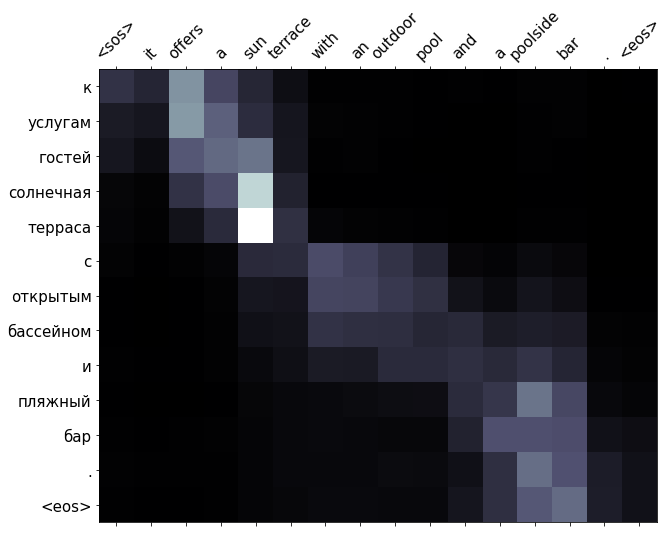

In [49]:
translation, attention = gru_translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {" ".join(translation)}')

gru_display_attention(src, translation, attention)

In [50]:
from my_utils import calculate_bleu

In [51]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 22.26
